<a href="https://colab.research.google.com/github/sidrusiya/AILA_Tasks/blob/main/Task1_LR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from google.colab import drive
# from textaugment import Wordnet, EDA, word2vec, Translate
# from nltk import WordNetLemmatizer
# from nltk.corpus import stopwords
import gensim
import re
import matplotlib.pyplot as plt
import seaborn as sns
# !pip3 install tensorflow_text
# import tensorflow_text
# !pip install -q tf-models-official
# !pip install -q -U tensorflow-text
# from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab
# import tensorflow_hub as hub
# import tensorflow_text as tf_text
from tqdm import tqdm

In [ ]:
!pip3 install transformers

     |████████████████████████████████| 3.1 MB 8.1 MB/s 
     |████████████████████████████████| 596 kB 57.0 MB/s 
     |████████████████████████████████| 59 kB 7.6 MB/s 
     |████████████████████████████████| 3.3 MB 46.1 MB/s 
     |████████████████████████████████| 895 kB 38.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import os
drive.mount('/content/drive')
PATH = '/content/drive/MyDrive/Task1/'
list_dir = os.listdir(PATH)
text = []
labels = []
for file in list_dir:
    file_path = PATH + file
    with open(file_path, 'r') as f:
        for line in f:
            line = line.split(sep='\t')
            text.append(line[0])
            labels.append(line[1][:-1])

data = {'Text': text, "labels": labels}
dataset1 = pd.DataFrame(data=data)

Mounted at /content/drive


In [ ]:
dataset1.head()

,Text,labels
0,The appellant who was arraigned as Accused 2 w...,Facts
1,"The allegations against the accused, inter ali...",Facts
2,Bindula Devi was married to Accused 1 Jaipraks...,Facts
3,The appellant and Accused 3 Shakun Devo Yadav ...,Facts
4,Accused 4 Dani Dutta Yadav is their father and...,Facts


In [ ]:
dataset1.shape

(11285, 2)

In [ ]:
dataset1.labels.value_counts()

Ratio of the decision      4211
Facts                      2622
Precedent                  1787
Argument                    939
Statute                     902
Ruling by Lower Court       483
Ruling by Present Court     341
Name: labels, dtype: int64

In [ ]:
event_types_dict = {}
for num, name in enumerate(list(dataset1['labels'].unique())):
    event_types_dict[name] = num
    # print(name, " : ", num)

event_types_dict

event_types_dict_inverse = {k:v for v,k in event_types_dict.items()}
print(event_types_dict)
print( event_types_dict_inverse)

{'Facts': 0, 'Ruling by Lower Court': 1, 'Argument': 2, 'Precedent': 3, 'Ratio of the decision': 4, 'Statute': 5, 'Ruling by Present Court': 6}
{0: 'Facts', 1: 'Ruling by Lower Court', 2: 'Argument', 3: 'Precedent', 4: 'Ratio of the decision', 5: 'Statute', 6: 'Ruling by Present Court'}


In [ ]:
def text_to_numerical_category(name):
    num = event_types_dict[name]
    return num

print(text_to_numerical_category('Facts'))
dataset1['num_labels'] = dataset1['labels'].apply(text_to_numerical_category)
dataset1

0


,Text,labels,num_labels
0,The appellant who was arraigned as Accused 2 w...,Facts,0
1,"The allegations against the accused, inter ali...",Facts,0
2,Bindula Devi was married to Accused 1 Jaipraks...,Facts,0
3,The appellant and Accused 3 Shakun Devo Yadav ...,Facts,0
4,Accused 4 Dani Dutta Yadav is their father and...,Facts,0
...,...,...,...
11280,"Suffice it to state that the appellant,as a fa...",Ratio of the decision,4
11281,"The High Court,in our view,declined,for good r...",Ratio of the decision,4
11282,We are also not persuaded to take a different ...,Ratio of the decision,4
11283,"In these circumstances,we are of the view that...",Ratio of the decision,4


In [ ]:
# Remove Excess [Size:: ] from EoS
def remove_size(text):
	result = re.search("\[size", text)
	if result is not None:
		text = text[:result.start()]
	return text.strip()

months = ['january', 'jan', 'feb', 'mar', 'apr', 'aug', 'sept', 'oct', 'nov', 'dec', 'feburary', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december', 'on']
def remove_months(text):
    text = text.split()
    text = [word for word in text if word.lower() not in set(months)]
    text = ' '.join(text)
    return text

def remove_nums(text):
    result = re.sub(r'[0-9+]', '', text)
    return result

def remove_comma(text):
    result = re.sub(r',', '', text)
    return result

In [ ]:
import sys
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
text = []
lem_text = []
for i in dataset1.index:
    dataset1['Text'][i] = remove_size(dataset1['Text'][i])
    dataset1['Text'][i] = remove_months(dataset1['Text'][i])
    dataset1['Text'][i] = remove_nums(dataset1['Text'][i])
    dataset1['Text'][i] = remove_comma(dataset1['Text'][i])
    temp = dataset1['Text'][i].lower().split()
    clean = [word for word in temp if word not in stopwords.words('english')]
    clean = " ".join(clean)
    text.append(clean)
    lem_text.append(clean)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dis

In [ ]:
for i in range(len(text)):
    text[i] = text[i].split()

In [ ]:
for i in range(len(lem_text)):
    lem_text[i] = lem_text[i].split()

In [ ]:
from nltk import PorterStemmer
st = PorterStemmer()
for i in range(len(text)):
    text[i] = [st.stem(word) for word in text[i]]

In [ ]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

for i in range(len(lem_text)):
    lem_text[i] = [lemmatizer.lemmatize(word) for word in lem_text[i]]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
for i in range(len(text)):
    text[i] = " ".join(text[i])

text[0]

'appel arraign accus tri along five accus offenc punish section read ss. ipc st addit session judg madhepura.'

In [ ]:
for i in range(len(lem_text)):
    lem_text[i] = " ".join(lem_text[i])

lem_text[0]

'appellant arraigned accused tried along five accused offence punishable section read ss. ipc st additional session judge madhepura.'

In [ ]:
dataset1['lem_text'] = np.array(lem_text)
dataset1['stem_text'] = np.array(text)

dataset1

,Text,labels,num_labels,lem_text,stem_text
0,The appellant who was arraigned as Accused wa...,Facts,0,appellant arraigned accused tried along five a...,appel arraign accus tri along five accus offen...
1,The allegations against the accused inter alia...,Facts,0,allegation accused inter alia subjected one bi...,alleg accus inter alia subject one bindula dev...
2,Bindula Devi was married to Accused Jaipraksh...,Facts,0,bindula devi married accused jaipraksh yadav.,bindula devi marri accus jaipraksh yadav.
3,The appellant and Accused Shakun Devo Yadav a...,Facts,0,appellant accused shakun devo yadav brother ac...,appel accus shakun devo yadav brother accus ja...
4,Accused Dani Dutta Yadav is their father and ...,Facts,0,accused dani dutta yadav father accused satya ...,accus dani dutta yadav father accus satya bham...
...,...,...,...,...,...
11280,Suffice it to state that the appellantas a fac...,Ratio of the decision,4,suffice state appellantas facthad used trade m...,suffic state appellanta facthad use trade mark...
11281,The High Courtin our viewdeclinedfor good reas...,Ratio of the decision,4,high courtin viewdeclinedfor good reasonsto re...,high courtin viewdeclinedfor good reasonsto re...
11282,We are also not persuaded to take a different ...,Ratio of the decision,4,also persuaded take different view high court,also persuad take differ view high court
11283,In these circumstanceswe are of the view that ...,Ratio of the decision,4,circumstanceswe view high court properly exerc...,circumstancesw view high court properli exerci...


In [ ]:
dataset1.labels.value_counts()

Ratio of the decision      4211
Facts                      2622
Precedent                  1787
Argument                    939
Statute                     902
Ruling by Lower Court       483
Ruling by Present Court     341
Name: labels, dtype: int64

In [ ]:
dataset1.drop_duplicates(['lem_text']).labels.value_counts()

Ratio of the decision      4146
Facts                      2566
Precedent                  1754
Argument                    905
Statute                     867
Ruling by Lower Court       476
Ruling by Present Court     276
Name: labels, dtype: int64

In [ ]:
from sklearn.utils import shuffle

lemm = []
labels = []
THRESH_1 = 1500
THRESH_2 = 500

for group in dataset1.labels.unique():
    if len(dataset1.groupby('labels').get_group(group).lem_text.unique()) > THRESH_1:
        lemm += (list(shuffle(dataset1.groupby('labels').get_group(group).lem_text.unique())))
        lemm += (list(shuffle(dataset1.groupby('labels').get_group(group).lem_text.unique())))
        labels += ([group]*2*len(list(shuffle(dataset1.groupby('labels').get_group(group).lem_text.unique()))))

    elif len(dataset1.groupby('labels').get_group(group).lem_text.unique()) > THRESH_2:
        lemm += (list(shuffle(dataset1.groupby('labels').get_group(group).lem_text.unique())))
        lemm += (list(shuffle(dataset1.groupby('labels').get_group(group).lem_text.unique())))
        lemm += (list(shuffle(dataset1.groupby('labels').get_group(group).lem_text.unique())))
        labels += ([group]*3*len(list(shuffle(dataset1.groupby('labels').get_group(group).lem_text.unique()))))
    else:
        lemm += (list(shuffle(dataset1.groupby('labels').get_group(group).lem_text.unique())))
        lemm += (list(shuffle(dataset1.groupby('labels').get_group(group).lem_text.unique())))
        lemm += (list(shuffle(dataset1.groupby('labels').get_group(group).lem_text.unique())))
        lemm += (list(shuffle(dataset1.groupby('labels').get_group(group).lem_text.unique())))
        lemm += (list(shuffle(dataset1.groupby('labels').get_group(group).lem_text.unique())))
        labels += ([group]*5*len(list(shuffle(dataset1.groupby('labels').get_group(group).lem_text.unique()))))

In [ ]:
balanced_df = pd.DataFrame({'Text' : lemm, 'Labels': labels})

In [ ]:
balanced_df.Labels.value_counts()

Ratio of the decision      8328
Facts                      5164
Precedent                  3528
Argument                   2754
Statute                    2619
Ruling by Lower Court      2410
Ruling by Present Court    1395
Name: Labels, dtype: int64

In [ ]:
balanced_df['NumLabel'] = balanced_df.Labels.apply(text_to_numerical_category)

In [ ]:
balanced_df.head()

,Text,Labels,NumLabel
0,fact narrated arjan singh village bangawali th...,Facts,0
1,case prosecution non-payment dowrythe accused ...,Facts,0
2,unable bear cruelty subjectedby accused person,Facts,0
3,sprouting blood seen left side chest shoulder ...,Facts,0
4,leave granted court ...,Facts,0


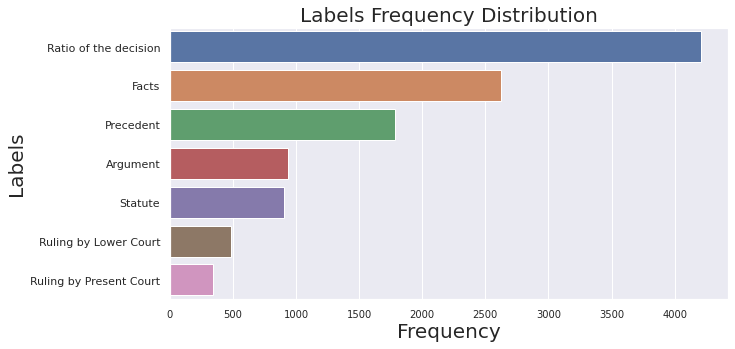

In [ ]:
sns.set_theme(style="darkgrid")
x = dataset1['labels'].value_counts()
y = x.index
plt.figure(figsize=(10, 5))
g = sns.barplot(x=x, y=y)
plt.title("Labels Frequency Distribution", fontsize=20)
plt.ylabel('Labels', fontsize= 20)
plt.yticks(fontsize=11)
plt.xlabel('Frequency', fontsize=20)
plt.xticks(fontsize=10)
plt.show()

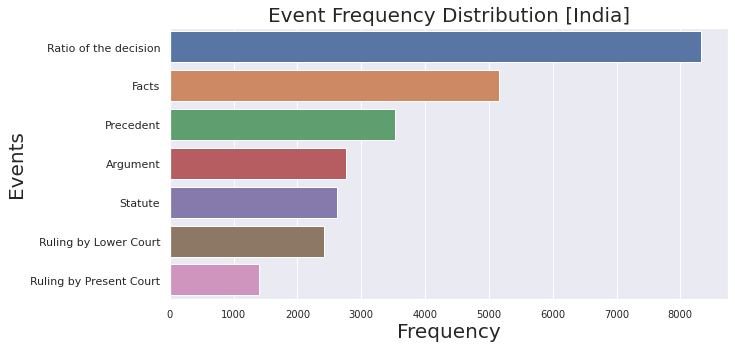

In [ ]:
sns.set_theme(style="darkgrid")
x = balanced_df.Labels.value_counts()
y = x.index
plt.figure(figsize=(10, 5))
g = sns.barplot(x=x, y=y)
plt.title("Event Frequency Distribution [India]", fontsize=20)
plt.ylabel('Events', fontsize= 20)
plt.yticks(fontsize=11)
plt.xlabel('Frequency', fontsize=20)
plt.xticks(fontsize=10)
plt.show()

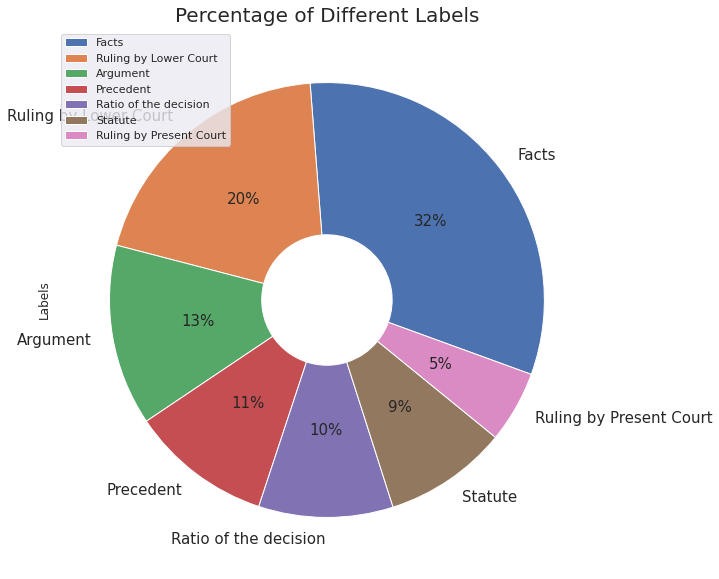

In [ ]:
plt.figure(figsize=(30,10))
plt.title('Percentage of Different Labels', fontsize=20)
balanced_df.Labels.value_counts().plot(kind='pie', labels= balanced_df.Labels.unique(),
                              wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle= -20, 
                              textprops={'fontsize': 15})
plt.legend(loc='upper left')
plt.show()

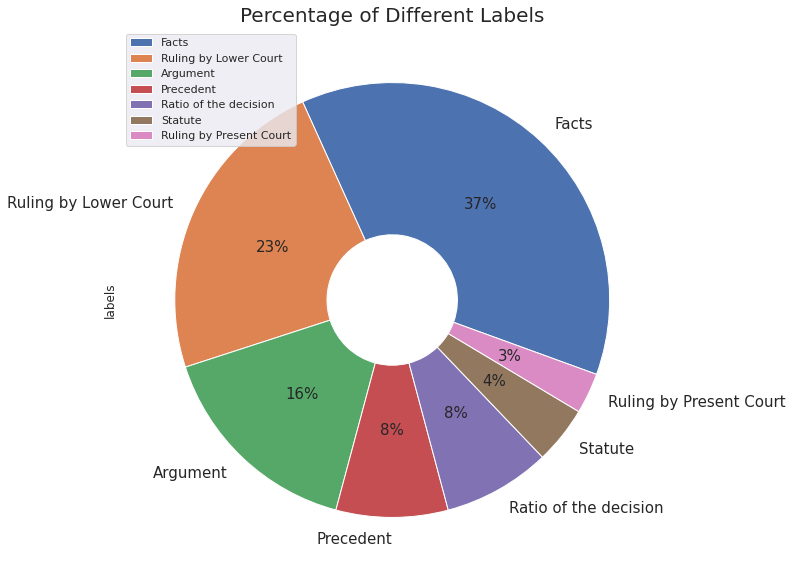

In [ ]:
plt.figure(figsize=(30,10))
plt.title('Percentage of Different Labels', fontsize=20)
dataset1.labels.value_counts().plot(kind='pie', labels= dataset1.labels.unique(),
                              wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle= -20, 
                              textprops={'fontsize': 15})
plt.legend(loc='upper left')
plt.show()

In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
result_df = shuffle(balanced_df)

In [ ]:
result_df

,Text,Labels,NumLabel
14247,would necessary consider evidence adduced pros...,Ratio of the decision,4
20503,mehtalearned counsel appearing respondentsthat...,Ratio of the decision,4
23585,a.().if suit instituted civil court involves i...,Statute,5
10977,sharad dutt () scc indlaw sc swati verma v,Precedent,3
23302,decision.on reading sub-s.()which quoted above...,Statute,5
...,...,...,...
8843,copyright literary work assigned reason said f...,Argument,2
11348,act.the magistrate committed case session cour...,Precedent,3
19951,body magistrate made subordinate high court,Ratio of the decision,4
937,u. talapathi,Facts,0


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(result_df.Text)

In [ ]:
type(X)

scipy.sparse.csr.csr_matrix

In [ ]:
X = X.toarray()

In [ ]:
type(X)

numpy.ndarray

In [ ]:
X.shape

(26198, 13742)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, result_df.NumLabel, test_size = 0.1, random_state = 42, stratify =result_df.NumLabel)

In [ ]:
from sklearn.linear_model import LogisticRegression
Log_Reg = LogisticRegression(random_state=0,solver='lbfgs')
Log_Reg.fit(X_train,Y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
Y_pred=Log_Reg.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
accuracy_score(Y_test,Y_pred)

0.75

In [ ]:
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.74      0.75      0.74       516
           1       0.88      0.80      0.84       241
           2       0.86      0.65      0.74       275
           3       0.84      0.60      0.70       353
           4       0.66      0.83      0.73       833
           5       0.80      0.73      0.76       262
           6       0.88      0.79      0.83       140

    accuracy                           0.75      2620
   macro avg       0.81      0.74      0.77      2620
weighted avg       0.77      0.75      0.75      2620



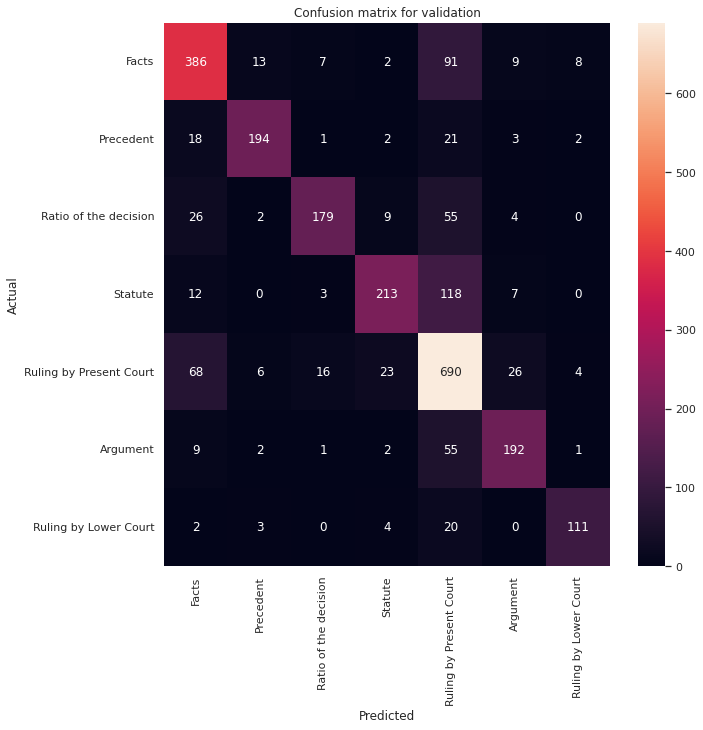

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(list(Y_test), list(Y_pred))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=set(result_df.Labels), yticklabels=set(result_df.Labels))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix for validation')
plt.show()

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
PATH = '/content/drive/MyDrive/Task1_Test/'
list_dir = os.listdir(PATH)
text = []
labels = []
sentid = []
i=0
for file in list_dir:
    file_path = PATH + file
    j=1
    i=i+1
    with open(file_path, 'r') as f:
        for line in f:
            line = line.split(sep='\t')
            text.append(line[0])
            labels.append(line[1][:-1])
            sentid.append("d"+str(i)+"_s"+str(j))
            j=j+1

data = {'ID': sentid, 'Text': text, "labels": labels}
test_file = pd.DataFrame(data=data)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Remove Excess [Size:: ] from EoS
def remove_size(text):
	result = re.search("\[size", text)
	if result is not None:
		text = text[:result.start()]
	return text.strip()

months = ['january', 'jan', 'feb', 'mar', 'apr', 'aug', 'sept', 'oct', 'nov', 'dec', 'feburary', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december', 'on']
def remove_months(text):
    text = text.split()
    text = [word for word in text if word.lower() not in set(months)]
    text = ' '.join(text)
    return text

def remove_nums(text):
    result = re.sub(r'[0-9+]', '', text)
    return result

def remove_comma(text):
    result = re.sub(r',', '', text)
    return result

In [ ]:
def text_cleaning(text):
    text = remove_size(text)
    text = remove_nums(text)
    text = remove_months(text)
    text = remove_comma(text)
    return text.strip().lower()

test_file['processed'] = test_file['Text'].apply(text_cleaning)

In [ ]:
test_file.head()

,ID,Text,labels,processed
0,d1_s1,These two Criminal Appeals are preferred by th...,Facts,these two criminal appeals are preferred by th...
1,d1_s2,Application no. 1295 of 2011 and 1296 of 2011 ...,Facts,application no. of and of passed by the learne...
2,d1_s3,"The respondent no. 1 Shyam Vithalrao Devkatta,...",Facts,the respondent no. shyam vithalrao devkatta fi...
3,d1_s4,Upon due verification process was issued by th...,Facts,upon due verification process was issued by th...
4,d1_s5,"Of these accused, four approached the Bombay H...",Facts,of these accused four approached the bombay hi...


In [ ]:
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

nltk.download('punkt')
from nltk import word_tokenize, WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
def lemmatizing_headlines(text):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in set(stopwords.words('english'))]
    return ' '.join(tokens).strip()

test_file['processed'] = test_file['processed'].apply(lemmatizing_headlines)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
test_file

,ID,Text,labels,processed
0,d1_s1,These two Criminal Appeals are preferred by th...,Facts,two criminal appeal preferred accused judgment...
1,d1_s2,Application no. 1295 of 2011 and 1296 of 2011 ...,Facts,application . passed learned single judge bomb...
2,d1_s3,"The respondent no. 1 Shyam Vithalrao Devkatta,...",Facts,respondent . shyam vithalrao devkatta filed co...
3,d1_s4,Upon due verification process was issued by th...,Facts,upon due verification process issued learned m...
4,d1_s5,"Of these accused, four approached the Bombay H...",Facts,accused four approached bombay high court way ...
...,...,...,...,...
692,d10_s60,"Applying the above principles, it is clear fro...",Ratio of the decision,applying principle clear finding two court cir...
693,d10_s61,Kalawati was last seen in the company of the a...,Ratio of the decision,kalawati last seen company appellant gher even...
694,d10_s62,"After his arrest, the production, by the appel...",Ratio of the decision,arrest production appellant ornament worn kala...
695,d10_s63,"To conclude, the appellant has been rightly co...",Ruling by Present Court,conclude appellant rightly convicted sentenced...


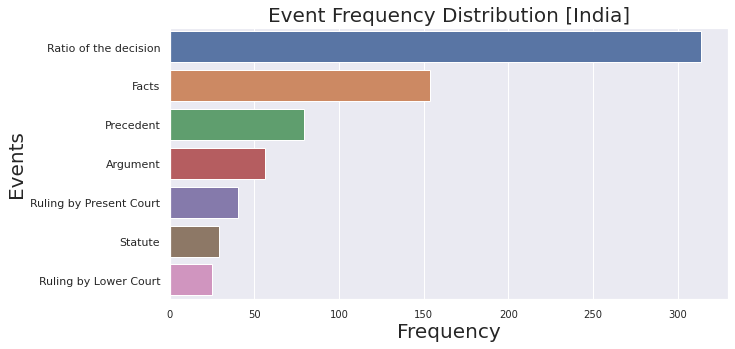

In [ ]:
sns.set_theme(style="darkgrid")
x = test_file.labels.value_counts()
y = x.index
plt.figure(figsize=(10, 5))
g = sns.barplot(x=x, y=y)
plt.title("Event Frequency Distribution [India]", fontsize=20)
plt.ylabel('Events', fontsize= 20)
plt.yticks(fontsize=11)
plt.xlabel('Frequency', fontsize=20)
plt.xticks(fontsize=10)
plt.show()

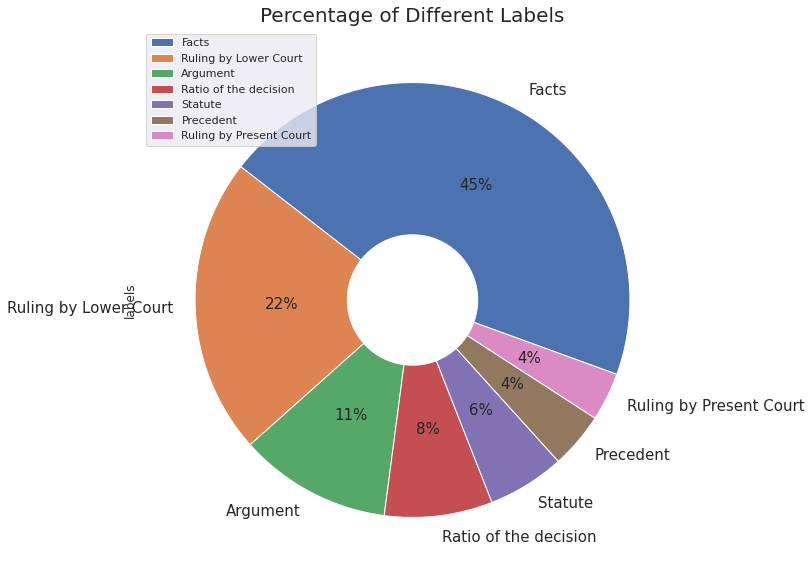

In [ ]:
plt.figure(figsize=(30,10))
plt.title('Percentage of Different Labels', fontsize=20)
test_file.labels.value_counts().plot(kind='pie', labels= test_file.labels.unique(),
                              wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle= -20, 
                              textprops={'fontsize': 15})
plt.legend(loc='upper left')
plt.show()